In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/yolo_classification/pytorch/default/1/yolov8_model.pt
/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/Pituitary/labels/Tr-pi_0818.txt
/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/Pituitary/labels/Tr-pi_0596.txt
/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/Pituitary/labels/Tr-pi_1428.txt
/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/Pituitary/labels/Tr-pi_0540.txt
/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/Pituitary/labels/Tr-pi_0532.txt
/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/Pituitary/labels/Tr-pi_0840.txt
/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/Pituitary/labels/Tr-pi_1251.txt
/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/Pituitary/labels/Tr-pi_0972.txt
/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/Pituitary/labels/Tr-pi_0470.txt
/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/Pituitary/labels/Tr-pi_0999.txt
/kaggle/input/mri-for-brain-tumo

In [2]:
# Install necessary libraries
!pip3 install ultralytics
!pip3 install plotly
!pip3 install opencv-python-headless



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.7/881.7 kB 8.1 MB/s eta 0:00:0000:0100:01


In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import yaml

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
# Import wandb and log in
!pip3 install wandb
import wandb

# Log in to wandb with API key
wandb.login(key='eb4c4a1fa7eec1ffbabc36420ba1166f797d4ac5')

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:

# Paths to data directories
train_path = "/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Train"
val_path = "/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val"


In [6]:
# Classes
classes = ["Glioma", "Meningioma", "No Tumor", "Pituitary"]

In [7]:
# Function to load images and labels
def load_data(data_path):
    images = []
    labels = []
    for class_label in classes:
        class_path = os.path.join(data_path, class_label, 'images')
        label_path = os.path.join(data_path, class_label, 'labels')
        for img_file in os.listdir(class_path):
            img = cv2.imread(os.path.join(class_path, img_file))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            label_file = img_file.replace('.jpg', '.txt')
            label_file_path = os.path.join(label_path, label_file)
            if os.path.exists(label_file_path):
                with open(label_file_path, 'r') as file:
                    label_data = file.readline().strip().split()
                    if len(label_data) > 0:
                        images.append(img)
                        labels.append(label_data)
                    else:
                        print(f"Label file {label_file_path} is empty, skipping this image.")
            else:
                print(f"Label file {label_file_path} not found, skipping this image.")
    return images, labels

# Load training and validation data
train_images, train_labels = load_data(train_path)
val_images, val_labels = load_data(val_path)

Label file /kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/Glioma/labels/gg (342).txt is empty, skipping this image.
Label file /kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/No Tumor/labels/image(61).txt not found, skipping this image.
Label file /kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/No Tumor/labels/image(55).txt not found, skipping this image.


In [8]:
# Image Preprocessing
def preprocess_images(images):
    processed_images = []
    for img in images:
        img_resized = cv2.resize(img, (640, 640))
        processed_images.append(img_resized)
    return np.array(processed_images)

train_images = preprocess_images(train_images)
val_images = preprocess_images(val_images)

In [9]:
yolo_model = YOLO("/kaggle/input/yolo_classification/pytorch/default/1/yolov8_model.pt")


0: 640x640 1 Glioma, 16.6ms
Speed: 5.5ms preprocess, 16.6ms inference, 335.4ms postprocess per image at shape (1, 3, 640, 640)


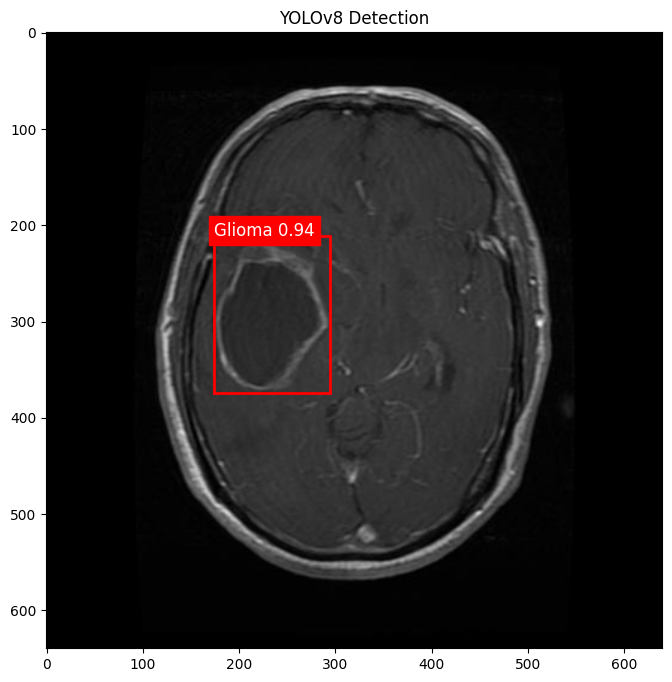


0: 640x640 1 Glioma, 16.3ms
Speed: 1.8ms preprocess, 16.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


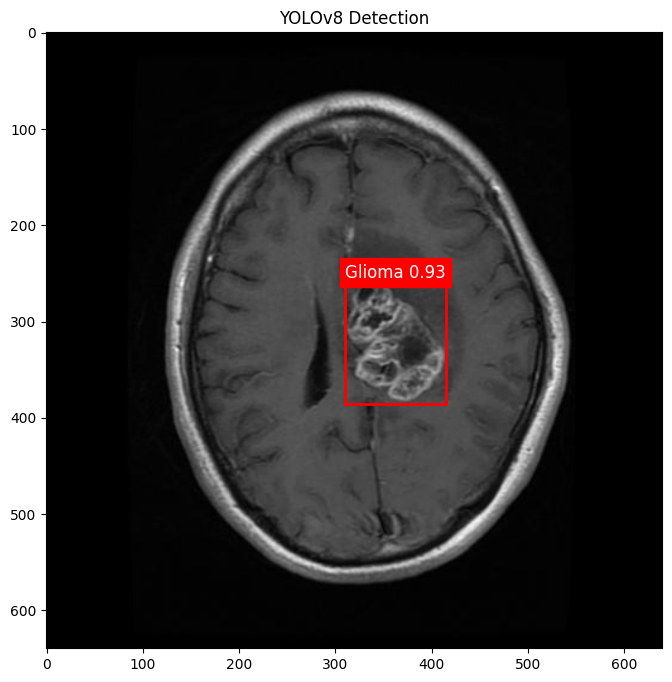


0: 640x640 1 Glioma, 16.3ms
Speed: 2.6ms preprocess, 16.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


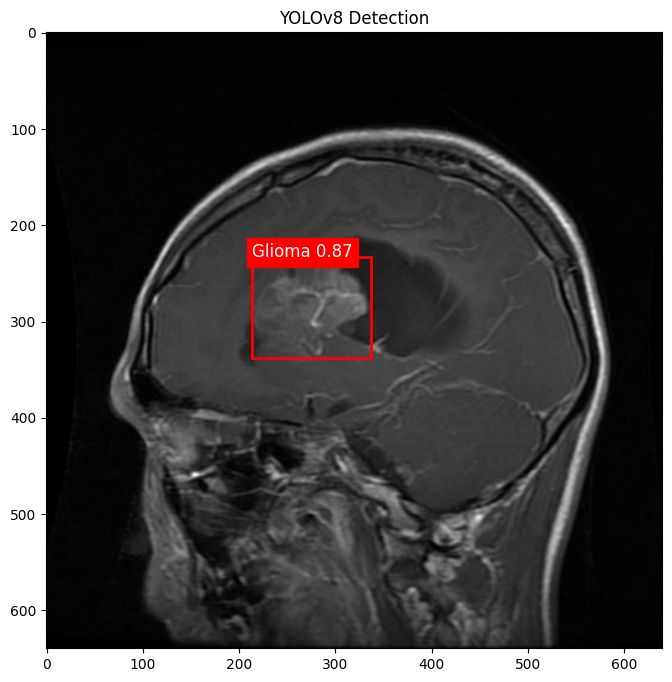


0: 640x640 1 Glioma, 1 Pituitary, 16.4ms
Speed: 2.3ms preprocess, 16.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


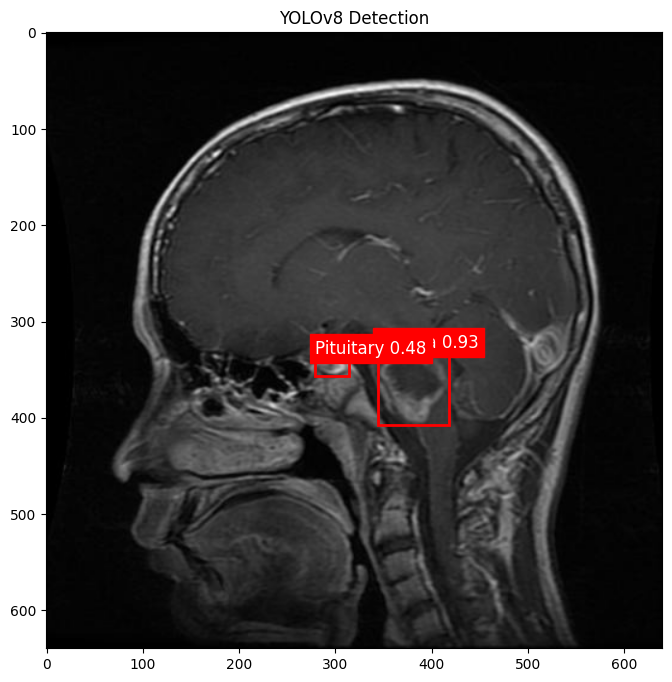


0: 640x640 1 Glioma, 16.4ms
Speed: 2.4ms preprocess, 16.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


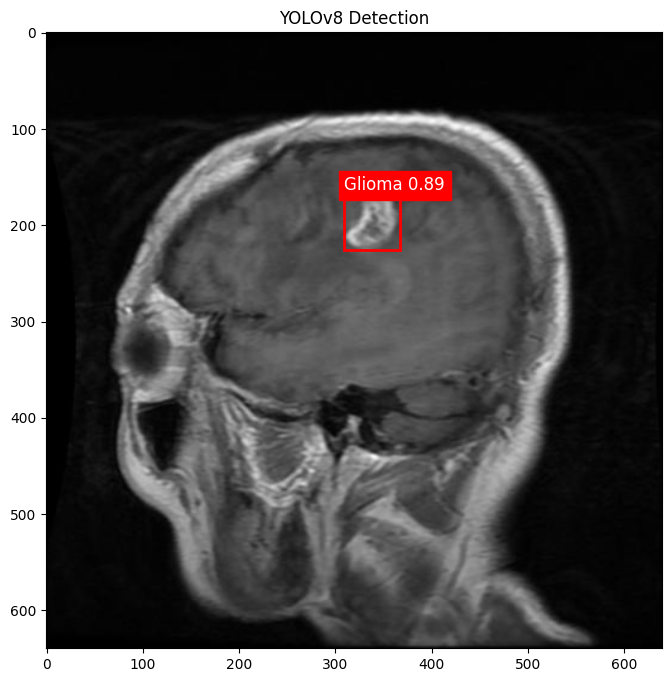


0: 640x640 1 Glioma, 1 Pituitary, 16.3ms
Speed: 1.8ms preprocess, 16.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


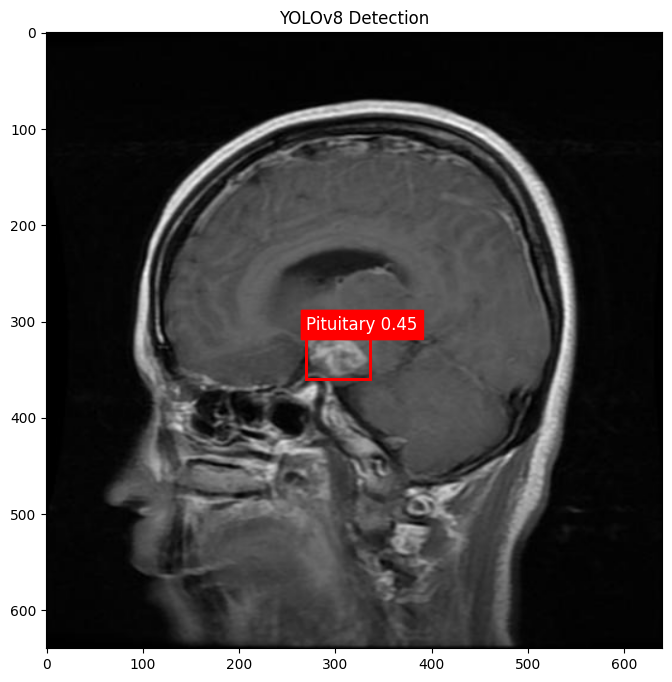


0: 640x640 1 Glioma, 16.4ms
Speed: 2.2ms preprocess, 16.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


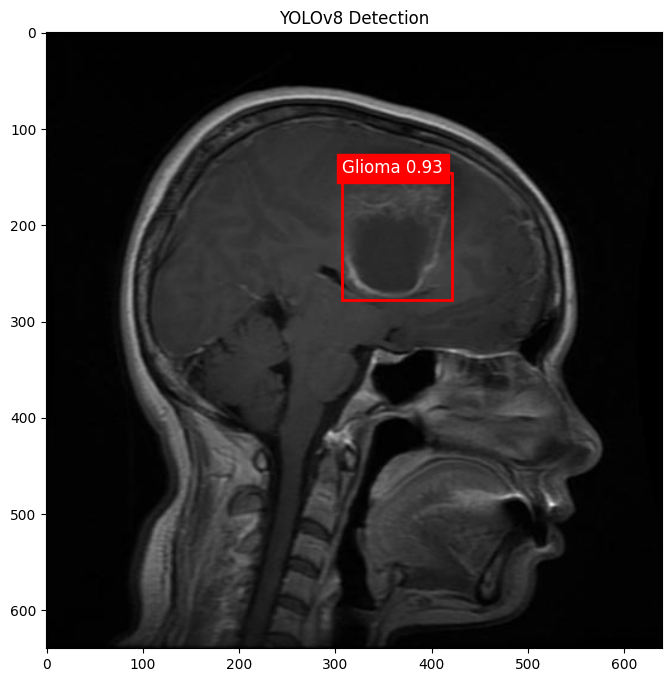


0: 640x640 1 Glioma, 16.3ms
Speed: 1.9ms preprocess, 16.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


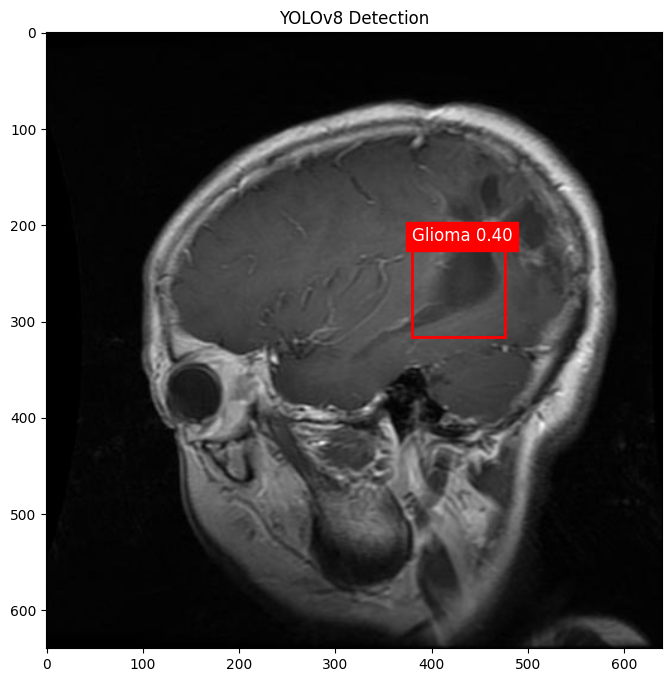


0: 640x640 1 Glioma, 1 Pituitary, 16.3ms
Speed: 2.1ms preprocess, 16.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


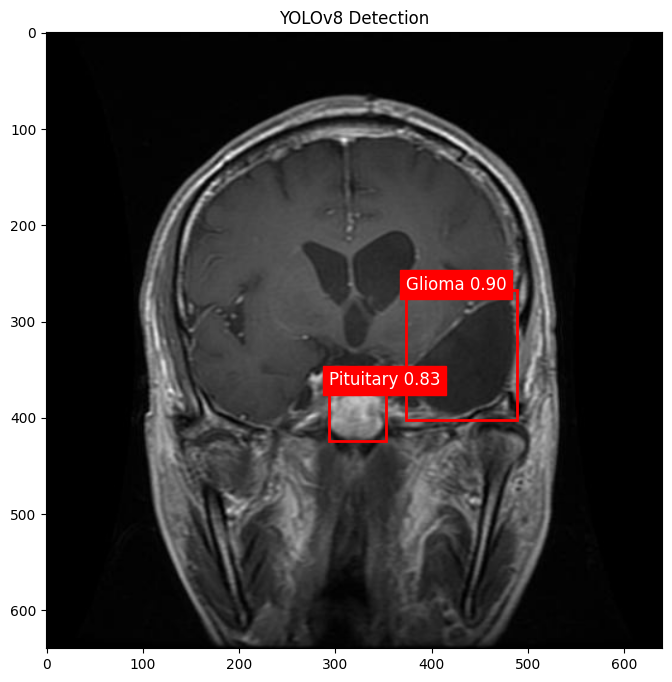


0: 640x640 1 Glioma, 16.3ms
Speed: 1.8ms preprocess, 16.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


In [ ]:
# Function to display detection results with highlighted parts
def display_samples(images, yolo_model):
    for i in range(10):
        img = images[i]
        result = yolo_model.predict(img)[0]  # Assuming batch size of 1, take the first result

        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        ax = plt.gca()

        for detection in result.boxes:
            x1, y1, x2, y2 = detection.xyxy[0].cpu().numpy()
            conf = detection.conf[0].cpu().numpy()
            cls = detection.cls[0].cpu().numpy()
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            plt.text(x1, y1, f"{classes[int(cls)]} {conf:.2f}", color='white', fontsize=12, backgroundcolor='red')
        
        plt.title(f'YOLOv8 Detection')
        plt.show()

display_samples(val_images, yolo_model)

In [15]:
correct_predictions = 0  # Counter for correct predictions
total_images = len(val_images)  # Total number of images

# Iterate through each image
for i in range(total_images):
    img = val_images[i]
    result = yolo_model.predict(img)[0]
    
    # Extract the predicted class (assume only one detection per image for simplicity)
    for detection in result.boxes:
        predicted_cls_index = int(detection.cls[0].cpu().numpy())  # Predicted class index
        predicted_class = classes[predicted_cls_index]  # Predicted class name
        
        # Compare with the true label (index)
        print(predicted_cls_index)  # This will print the predicted class index
        print(val_labels[i])  # This will print the actual class label for comparison
        if predicted_cls_index == val_labels[i][0]:  # If predicted class matches the true class
            correct_predictions += 1  # Increment correct predictions count
        print("Predicted - ", correct_predictions)  # This prints the number of correct predictions so far

# Calculate accuracy
accuracy = correct_predictions / total_images * 100
print(accuracy)  # This prints the final accuracy percentage


0: 640x640 1 Glioma, 16.4ms
Speed: 2.5ms preprocess, 16.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
0
['0', '0.365234', '0.456055', '0.191406', '0.255859']
Predicted -  0

0: 640x640 1 Glioma, 16.3ms
Speed: 1.8ms preprocess, 16.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
0
['0', '0.565430', '0.499023', '0.162109', '0.205078']
Predicted -  0

0: 640x640 1 Glioma, 16.3ms
Speed: 2.3ms preprocess, 16.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
0
['0', '0.428711', '0.444336', '0.193359', '0.158203']
Predicted -  0

0: 640x640 1 Glioma, 1 Pituitary, 16.3ms
Speed: 1.8ms preprocess, 16.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
0
['0', '0.596680', '0.572266', '0.119141', '0.125000']
Predicted -  0
3
['0', '0.596680', '0.572266', '0.119141', '0.125000']
Predicted -  0

0: 640x640 1 Glioma, 16.3ms
Speed: 2.2ms preprocess, 16.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
0


In [16]:
correct_predictions = 0  # Counter for correct predictions
total_images = len(val_images)  # Total number of images

# Iterate through each image
for i in range(total_images):
    img = val_images[i]
    result = yolo_model.predict(img)[0]
    # Accessing detection boxes from the result
    for detection in result.boxes:
        predicted_cls_index = int(detection.cls[0].cpu().numpy())  # Predicted class index
        predicted_class = classes[predicted_cls_index]  # Map index to class name
        print("predicted Index: ",predicted_cls_index)
        print("Actual Index: ",val_labels[i][0])
        print(f"Predicted class: {predicted_class}")
        



0: 640x640 1 Glioma, 16.4ms
Speed: 2.5ms preprocess, 16.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
predicted Index:  0
Actual Index:  0
Predicted class: Glioma

0: 640x640 1 Glioma, 16.4ms
Speed: 2.3ms preprocess, 16.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
predicted Index:  0
Actual Index:  0
Predicted class: Glioma

0: 640x640 1 Glioma, 16.3ms
Speed: 1.7ms preprocess, 16.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
predicted Index:  0
Actual Index:  0
Predicted class: Glioma

0: 640x640 1 Glioma, 1 Pituitary, 16.3ms
Speed: 1.9ms preprocess, 16.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
predicted Index:  0
Actual Index:  0
Predicted class: Glioma
predicted Index:  3
Actual Index:  0
Predicted class: Pituitary

0: 640x640 1 Glioma, 16.3ms
Speed: 1.8ms preprocess, 16.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
predicted Index:  0
Actual Index:  0
Predicted cl

In [17]:
correct_predictions = 0  # Counter for correct predictions
total_images = len(val_images)  # Total number of images
for i in range(total_images):
    img = val_images[i]
    result = yolo_model.predict(img)[0]  # Get the predictions for the image
    
    # Initialize variables to store the detection with the highest confidence
    best_conf = -1  # To track the best confidence score
    best_class_index = None  # To track the best predicted class
    
    # Extract the predicted class with the highest confidence
    for detection in result.boxes:
        conf = detection.conf[0].cpu().numpy()  # Confidence score of the prediction
        cls = int(detection.cls[0].cpu().numpy())  # Predicted class index
        
        if conf > best_conf:  # Update if the current confidence is higher
            best_conf = conf
            best_class_index = cls
    
    if best_class_index is not None:
        # Compare the best prediction with the ground truth label
        if best_class_index == int(val_labels[i][0]):
            correct_predictions += 1  # Increment correct predictions count
            
accuracy = correct_predictions / total_images * 100




0: 640x640 1 Glioma, 16.4ms
Speed: 3.1ms preprocess, 16.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Glioma, 16.3ms
Speed: 2.4ms preprocess, 16.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Glioma, 16.3ms
Speed: 1.8ms preprocess, 16.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Glioma, 1 Pituitary, 16.3ms
Speed: 2.1ms preprocess, 16.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Glioma, 16.3ms
Speed: 2.0ms preprocess, 16.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Glioma, 1 Pituitary, 16.3ms
Speed: 1.7ms preprocess, 16.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Glioma, 16.3ms
Speed: 1.9ms preprocess, 16.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Glioma, 16.3ms
Speed: 2.4ms preprocess, 16.3ms inference, 1.6ms postprocess pe

In [18]:
print("The accuracy of the model is: ",accuracy)

The accuracy of the model is:  98.62475442043221
